In [ ]:
import torch
import torchvision
from torchvision.datasets import MNIST 
import torchvision.transforms as transforms 
import numpy as np

In [ ]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
dataset = MNIST("", download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



In [ ]:
test = MNIST("", train= False, transform = transforms.ToTensor())
train = MNIST("", train= True, transform = transforms.ToTensor())

In [ ]:
train_x , val_x = random_split(train, [50000, 10000])

In [ ]:
batch_size = 128

In [ ]:
train_loader = DataLoader(train_x, batch_size, shuffle=True)
val_loader = DataLoader(val_x, batch_size)

In [ ]:
class MNIST_Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(784, 10)
  
  def forward(self, Xs):
    x = self.layer1(Xs)
    return x
  def training_step(self, batch):
    images , labels = batch
    images = images.view(-1 ,784)
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    images = images.view(-1 ,784) 
    out = self(images)                    # Generate predictions
    loss = F.cross_entropy(out, labels)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss, 'val_acc': acc}
      
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
  
  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MNIST_Model()

In [ ]:
for batch in train_loader:
  images , labels = batch
  images = images.view(-1, 28*28)
  print(images.shape)
  output = model(images)
  break

torch.Size([128, 784])


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [ ]:
probs = F.softmax(output, dim = 1)

In [ ]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([6, 6, 9, 6, 6, 2, 6, 5, 7, 9, 6, 6, 4, 2, 9, 6, 6, 6, 6, 6, 9, 7, 7, 2,
        6, 2, 6, 7, 9, 7, 6, 6, 7, 7, 6, 2, 7, 6, 6, 9, 5, 6, 6, 6, 6, 8, 6, 6,
        6, 7, 6, 2, 6, 2, 7, 6, 4, 2, 9, 9, 6, 6, 2, 0, 6, 6, 6, 6, 9, 7, 6, 7,
        9, 6, 6, 6, 6, 9, 9, 6, 6, 9, 2, 6, 2, 9, 6, 6, 6, 2, 6, 7, 9, 6, 6, 6,
        1, 6, 6, 6, 6, 9, 6, 7, 6, 6, 9, 6, 9, 6, 6, 6, 6, 6, 6, 2, 4, 9, 9, 1,
        6, 9, 2, 6, 9, 6, 7, 2])
tensor([0.1454, 0.1468, 0.1242, 0.1246, 0.1260, 0.1187, 0.1464, 0.1312, 0.1373,
        0.1375, 0.1375, 0.1250, 0.1223, 0.1454, 0.1382, 0.1322, 0.1611, 0.1216,
        0.1366, 0.1410, 0.1302, 0.1128, 0.1201, 0.1252, 0.1177, 0.1305, 0.1712,
        0.1254, 0.1421, 0.1148, 0.1373, 0.1304, 0.1217, 0.1171, 0.1225, 0.1298,
        0.1245, 0.1399, 0.1474, 0.1140, 0.1383, 0.1274, 0.1586, 0.1211, 0.1295,
        0.1171, 0.1421, 0.1372, 0.1464, 0.1194, 0.1299, 0.1710, 0.1543, 0.1206,
        0.1285, 0.1361, 0.1322, 0.1389, 0.1408, 0.1330, 0.1291, 0.1360, 0.1382,
       

In [ ]:
opt = torch.optim.SGD
x = opt(model.parameters(), lr = 0.001)

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  optimizer = opt_func(model.parameters(), lr)
  history = []

  for epoch in range(epochs):      
  
    # Training Phase 
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # Validation Phase 
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  
  return history

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
hist = fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9503, val_acc: 0.6240
Epoch [1], val_loss: 1.6775, val_acc: 0.7375
Epoch [2], val_loss: 1.4738, val_acc: 0.7735
Epoch [3], val_loss: 1.3199, val_acc: 0.7951
Epoch [4], val_loss: 1.2015, val_acc: 0.8084
Epoch [5], val_loss: 1.1085, val_acc: 0.8200
Epoch [6], val_loss: 1.0340, val_acc: 0.8266
Epoch [7], val_loss: 0.9729, val_acc: 0.8313
Epoch [8], val_loss: 0.9222, val_acc: 0.8357
Epoch [9], val_loss: 0.8792, val_acc: 0.8397


In [ ]:
hist[0]

{'val_acc': 0.6240110993385315, 'val_loss': 1.950284719467163}

In [ ]:
accuracies = [accuracy["val_acc"] for accuracy in hist]

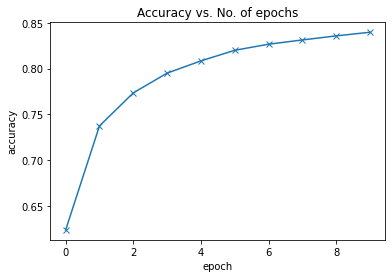

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [ ]:
img , label = test[111]

In [ ]:
res = model(img.view(-1, 784))

In [ ]:
probs = F.softmax(res, dim=1)

In [ ]:
max_probs , pred = torch.max(probs, dim=1)
label == pred

tensor([False])

In [ ]:
img.view(-1,784).shape

torch.Size([1, 784])

In [ ]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [ ]:
forRelu = torch.randint(-10,20,(5,10))

In [ ]:
for i,x in forRelu.itterrows():
  print(i,x)

AttributeError: ignored